[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/10TwYiQNsPGsztoGPLm13JzJtFTFNN8-u?usp=sharing)


In [1]:
%pip install pinecone
%pip install langchain
%pip install langchain-community
%pip install langchain-core
%pip install PyPDF2
%pip install -qU langchain_mistralai
%pip install mistralai
%pip install markdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.6/271.6 kB 11.0 MB/s eta 0:00:00


In [2]:
import os
from typing import List, Dict
import pinecone
import PyPDF2
import numpy as np
from tqdm.auto import tqdm
from dotenv import load_dotenv
import getpass
from langchain_mistralai import ChatMistralAI,MistralAIEmbeddings
from mistralai.client import MistralClient
import markdown

### Utils - just for visualization

In [3]:
%pip install -qU rich

In [4]:
from rich.console import Console
from rich.panel import Panel
from rich.text import Text
from rich.syntax import Syntax
from rich.table import Table
from typing import Any

console = Console()
def print_model_response(input_text: str, model_response: Any, model_name: str = "assistant") -> None:

    # Input Panel
    input_panel = Panel(
        Text(input_text, style="blue"), title="📝 Input Text", border_style="blue"
    )

    # Response Panel
    if isinstance(model_response, dict):
        table = Table(show_header=True, header_style="bold magenta")
        table.add_column("Key", style="cyan")
        table.add_column("Value", style="yellow")

        for key, value in model_response.items():
            table.add_row(str(key), str(value))

        response_content = table
    else:
        response_content = Text(str(model_response), style="yellow")

    response_panel = Panel(
        response_content, title=model_name+"🤖 Response", border_style="magenta"
    )

    console.print("\n" + "=" * 80 + "\n")
    console.print(input_panel)
    console.print(response_panel)
    console.print("\n" + "=" * 80 + "\n")


### FIRST STEP: SET YOUR API-KEYS

In [5]:
from google.colab import userdata
import getpass
import os

# Mistral API Key
if "MISTRAL_API_KEY" not in os.environ:
    try:
        os.environ["MISTRAL_API_KEY"] = userdata.get('MISTRAL_API_KEY')
    except Exception as e:
        os.environ["MISTRAL_API_KEY"] = getpass.getpass("Provide your Mistral API Key: ")

In [6]:
llm_mistral = ChatMistralAI(model="mistral-tiny", temperature=0)

### PINECONE

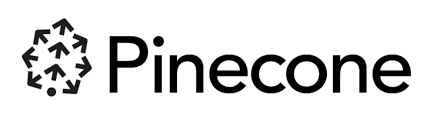


https://www.pinecone.io/


In [7]:
if "PINECONE_API_KEY" not in os.environ:
    try:
        os.environ["PINECONE_API_KEY"] = userdata.get('PINECONE_API_KEY')
    except Exception as e:
        os.environ["PINECONE_API_KEY"] = getpass.getpass("Provide your PINECONE API Key: ")

In [8]:
from pinecone import Pinecone, ServerlessSpec
pc = Pinecone(api_key=os.environ["PINECONE_API_KEY"])
spec = ServerlessSpec(
    cloud='aws',
    region='us-east-1'
)

In [9]:
# Test embedding size
llm = ChatMistralAI(model="mistral-tiny", temperature=0)
embeddings = MistralAIEmbeddings(model="mistral-embed")
dim = len(embeddings.embed_query("test"))
print(f"Embedding dimension: {dim}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/langchain_mistralai/embeddings.py:181: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


Embedding dimension: 1024


In [10]:
# Crea/recupera indice
index_name = "academic-papers"
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=dim,
        metric='cosine',
        spec=spec
    )
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)
index = pc.Index(index_name)

In [12]:
with open('paper1.pdf', 'rb') as file:
    reader = PyPDF2.PdfReader(file)
    text = ""
    for page in reader.pages:
        text += page.extract_text()

In [13]:
#Crea chunk (1000 caratteri con 200 di overlap)
chunks = []
chunk_size = 1000
overlap = 200
start = 0
while start < len(text):
    end = start + chunk_size
    if end < len(text):
        end = text.rfind(' ', start, end)
    chunks.append(text[start:end].strip())
    start = end - overlap

In [14]:
len(chunks)

80

In [15]:
print(markdown.markdown(chunks[0]))

<p>Received 10 December 2024; accepted 15 December 2024. Date of publication 18 December 2024;
date of current version 9 January 2025. The review of this article was arranged by Associate Editor Peng Li.
Digital Object Identiﬁer 10.1109/OJCS.2024.3519747
Reducing Data Volume in News Topic
Classiﬁcation: Deep Learning Framework
and Dataset
LUIGI SERRELI1,2(Member, IEEE), CLAUDIO MARCHE1,2(Member, IEEE),
AND MICHELE NITTI1,2(Senior Member, IEEE)
1Department of Electrical and Electronic Engineering (DIEE), University of Cagliari, 09123 Cagliari, Italy
2Research Unit of Cagliari, National Telecommunication Inter University Consortium 09123 Cagliari, Italy
CORRESPONDING AUTHOR: LUIGI SERRELI (e-mail: luigi.serreli@unica.it).
This work was supported by the Ministero dell’Istruzione, dell’Universita e della Ricerca (MIUR) with the PON “Ricerca e Innovazione” 2014-2020 (PO N RI)
“Azione IV.5 Dottorati su tematiche green”, assigned with D.M. 1062 on 10.08.2021.
ABSTRACT Withthe rise of smart</p

In [16]:
print(markdown.markdown(chunks[1]))

<p>ersita e della Ricerca (MIUR) with the PON “Ricerca e Innovazione” 2014-2020 (PO N RI)
“Azione IV.5 Dottorati su tematiche green”, assigned with D.M. 1062 on 10.08.2021.
ABSTRACT Withthe rise of smart devices and technological advancements, accessing vast amounts of infor-
mation has become easier than ever before. However, sorting and categorising such an overwhelming volume
of content has become increasingly challenging. This article introduces a new framework for classifying
news articles based on a Bidirectional LSTM (BiLSTM) network and an attention mechanism. The article
also presents a new dataset of 60 000 news articles from various global sources. Furthermore, it proposes a
methodology for reducing data volume by extracting key sentences using an algorithm resulting in inference
times that are, on average, 50% shorter than the original document without compromising the system’s
accuracy. Experimental evaluations demonstrate that our framework outperforms existing</p>


In [17]:
import time

In [18]:
# Crea embeddings e Carica su PineCone
batch_size = 10
for i in tqdm(range(0, len(chunks), batch_size)):
    # Prendi il batch corrente
    batch = chunks[i:i+batch_size]
    ids = [f"chunk_{j}" for j in range(i, i+len(batch))]

    # Crea embeddings con pausa tra ogni chiamata
    embeddings_batch = []
    for chunk in batch:
        emb = embeddings.embed_query(chunk)
        embeddings_batch.append(emb)
        time.sleep(2)

    # Upsert su Pinecone
    vectors = list(zip(ids, embeddings_batch, [{"text": text} for text in batch]))
    index.upsert(vectors=vectors)
    time.sleep(2)  # 1 secondo di pausa tra i batch

  0%|          | 0/8 [00:00<?, ?it/s]

Let us make a question

In [20]:

query = "What are the main contributions of the paper?"
query_embedding = embeddings.embed_query(query)
time.sleep(0.5)

results = index.query(vector=query_embedding, top_k=3, include_metadata=True)

In [21]:
results

{'matches': [{'id': 'chunk_74',
              'metadata': {'text': '“Semisupervised learning-based\n'
                                   'word-sense disambiguation using word '
                                   'embedding for afaan oro-\n'
                                   'moo language,” Appl. Comput. Intell. Soft '
                                   'Comput. , vol. 2024, 2024,\n'
                                   'Art. no. 4429069.\n'
                                   '[29] K. Patel and P. Bhattacharyya, '
                                   '“Towards lower bounds on number of\n'
                                   'dimensions for word embeddings,” in Proc. '
                                   '8th Int. Joint Conf. Nat-\n'
                                   'ural Lang. Process. , G. Kondrak and T. '
                                   'Watanabe, Eds., Nov. 2017,\n'
                                   'pp. 31–36.\n'
                                   '[30] K. Schrøder, “What do news r

Get a response

In [22]:
context = [match.metadata["text"] for match in results.matches]
prompt = f"""Given the context, Try answering the question.
If the response is not in the context, say it explicitly.

Context:
{' '.join(context)}

Question: {query}
"""
response = llm_mistral.invoke(prompt)
print(response)

content="The main contributions of the paper, as outlined in the context, are:\n\n1. Proposing a new framework for classifying news articles based on a Bidirectional LSTM (BiLSTM) network and an attention mechanism.\n2. Introducing a new dataset of 60,000 news articles from various global sources.\n3. Developing a methodology for reducing data volume by extracting key sentences using an algorithm, resulting in inference times that are, on average, 50% shorter than the original document without compromising the system's accuracy.\n\nThe paper claims that this framework outperforms existing methods." additional_kwargs={} response_metadata={'token_usage': {'prompt_tokens': 1019, 'total_tokens': 1156, 'completion_tokens': 137}, 'model': 'mistral-tiny', 'finish_reason': 'stop'} id='run-5c039fce-8e20-411f-9216-855ad24efc68-0' usage_metadata={'input_tokens': 1019, 'output_tokens': 137, 'total_tokens': 1156}


### RAG and CSV

In [ ]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from pathlib import Path
import os


In [ ]:
!pip install -q kagglehub
!pip install -q faiss-cpu

In [ ]:
import kagglehub
path = kagglehub.dataset_download("amirkaviani0/customers-100")
path = path+"/customers-100.csv"

In [ ]:
import pandas as pd
df = pd.read_csv(path)
df.head()

In [ ]:
loader = CSVLoader(file_path=path)
docs = loader.load_and_split()

In [ ]:
docs

In [ ]:
llm = ChatMistralAI(model="mistral-tiny", temperature=0)
embeddings = MistralAIEmbeddings(model="mistral-embed")

In [ ]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

index = faiss.IndexFlatL2(len(embeddings.embed_query(" ")))
vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={}
)

In [ ]:
vector_store.add_documents(documents=docs)

In [ ]:
retriever = vector_store.as_retriever()

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

# Define the system prompt with a clear instruction for the assistant
system_prompt = (
    "You are an AI assistant designed to answer questions. "
    "Utilize the provided context to formulate your response. "
    "If the context does not contain enough information to answer the question, "
    "simply state that you do not know. Keep your response concise."
    "\n\n"
    "{context}"
)

# Create a ChatPromptTemplate with the system prompt and user input
chat_prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),  # System message with instructions
    ("human", "{input}"),       # User's question or input
])

# Create a chain that processes documents and generates answers
document_processing_chain = create_stuff_documents_chain(llm, chat_prompt)

# Combine the document processing chain with a retriever to form the RAG chain
rag_chain = create_retrieval_chain(retriever, document_processing_chain)

In [ ]:
answer= rag_chain.invoke({"input": "Tell me all you know about Linda	Olsen"})
answer['answer']

### Slower Approach (if you get "too many requests" error)

In [ ]:
import faiss
import numpy as np
from tqdm import tqdm
import time
dimension = len(embeddings.embed_query(""))
index = faiss.IndexFlatL2(dimension)

all_embeddings = []
for doc in tqdm(docs):
    embedding = embeddings.embed_query(doc.page_content)
    time.sleep(2)
    all_embeddings.append(embedding)

embeddings_array = np.array(all_embeddings).astype('float32')
index.add(embeddings_array)

# Crea il vector store
vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={}
)

In [ ]:
vector_store = FAISS.from_documents(docs, embeddings)

In [ ]:
retriever = vector_store.as_retriever()

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

# Define the system prompt with a clear instruction for the assistant
system_prompt = (
    "You are an AI assistant designed to answer questions. "
    "Utilize the provided context to formulate your response. "
    "If the context does not contain enough information to answer the question, "
    "simply state that you do not know. Keep your response concise."
    "\n\n"
    "{context}"
)

# Create a ChatPromptTemplate with the system prompt and user input
chat_prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),  # System message with instructions
    ("human", "{input}"),       # User's question or input
])

# Create a chain that processes documents and generates answers
document_processing_chain = create_stuff_documents_chain(llm, chat_prompt)

# Combine the document processing chain with a retriever to form the RAG chain
rag_chain = create_retrieval_chain(retriever, document_processing_chain)

In [ ]:
answer= rag_chain.invoke({"input": "Tell me all you know about Linda	Olsen"})


In [ ]:
answer